<a href="https://colab.research.google.com/github/Nuthan03/NLP/blob/main/Introduction_to_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intorduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language(could be seqeuences of texts or speech).
Another common term for NLP problems is sequence to sequence problems(seq2seq)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2ffab0e6-64b3-96b7-7174-50c95007e9ae)


## Get the helper functions


In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper function for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-12-16 05:50:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-12-16 05:50:21 (12.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset
The dataset we are going to be using us Kaggle's introduction to NLP datasets (text samples of Tweets labelled as diaster or not diaster).

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-12-16 05:50:25--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 108.177.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   953KB/s    in 0.6s    

2023-12-16 05:50:26 (953 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/


In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like ?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real diaster)" if target > 0 else "(not real diaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real diaster)
Text:
My brains going to explode i need to leave this house. Ill be out smoking packs if you need me

---

Target: 0 (not real diaster)
Text:
Don't like those head first slides. Especially into home !! #danger

---

Target: 0 (not real diaster)
Text:
@YahooSchwab easy way to look good after the Ray Rice fiasco...that blew up

---

Target: 0 (not real diaster)
Text:
Bulgarian Tittie Twister By NoEmotion Produced By EDK PathFinders (HD) M...: http://t.co/9ODqryJncF via YouTube

---

Target: 1 (real diaster)
Text:
Bolshevik government monopolized food supply to seize power over hunhry population. Artificial famine was the result https://t.co/0xOUv7DHWz

---



## Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use train_test_split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this namely:
* Tokenziation-direct mapping of token(a token could be a word or a character) to number
* Embedding-create a martrix of feature vector for each token(the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization(tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # How many words in the vocabullary
                                    standardize="lower_and_strip_punctuation", # How to process text
                                    split="whitespace", # How to split tokens
                                    ngrams=None, # Grouping words is none
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # How long should the output sequence of tokens be?
                                    #pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization wtth custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 ME says many of these wounds could be fatal some rather quickly others slower and a couple not lethal at all. #KerrickTrial        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  31,  296,  123,    6,  222,  523,  137,   21,  163,   82, 1263,
        1786,  731, 3404,    7]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we are going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:


*   `input_dim` = the size of our vocabulary.
*   `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
*   `input_length` = length of the sequences being passed to the embedding layer



In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform",
                             input_length=max_length, # how long is each input
                             name="embedding")

embedding


In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
       \n\nEmbedded version")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@Michael5SOS FUCKING LIVE HERE IM SURPRISED IVE SURVIVED THIS LONG       

Embedded version


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02656388,  0.01415631,  0.01778768, ..., -0.04279293,
         -0.04718906, -0.00467651],
        [ 0.02820251, -0.02948575,  0.03787233, ..., -0.00039925,
          0.00813975, -0.03040521],
        [ 0.0474872 ,  0.0411472 , -0.04732066, ..., -0.02668822,
         -0.02836173,  0.00219622],
        ...,
        [-0.03087184,  0.02448103,  0.04021339, ..., -0.0092098 ,
          0.0147424 ,  0.04001885],
        [-0.03087184,  0.02448103,  0.04021339, ..., -0.0092098 ,
          0.0147424 ,  0.04001885],
        [-0.03087184,  0.02448103,  0.04021339, ..., -0.0092098 ,
          0.0147424 ,  0.04001885]]], dtype=float32)>

In [ ]:
# Chcek out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02656388,  0.01415631,  0.01778768, -0.02501755, -0.02302342,
        -0.01944842, -0.04143534,  0.02571272, -0.02219402, -0.01048135,
        -0.03469379,  0.00262003, -0.04503239,  0.01352621, -0.0217826 ,
         0.00047097,  0.03875614, -0.04844285, -0.01051296, -0.01689696,
         0.02110672,  0.03564619, -0.04738697,  0.00399442,  0.03815121,
        -0.03008943, -0.03919911,  0.03292317, -0.0493503 ,  0.03137204,
         0.01120023,  0.04959989,  0.03857341,  0.0480459 ,  0.02435929,
         0.02778708,  0.03666521, -0.02238367, -0.01727873, -0.01927098,
        -0.00131439,  0.03303336,  0.01402   ,  0.01525002, -0.02795373,
        -0.04461044,  0.01031618,  0.00404143, -0.04972233, -0.0414295 ,
         0.03818264, -0.00047625,  0.01252422, -0.01385693,  0.00091673,
         0.03662539,  0.0082677 ,  0.04273689, -0.03141984,  0.0052035 ,
        -0.02750731,  0.01857764, -0.04774674,  0.02855528,  0.02219658,
  

## Modelling a text dataset

Now we have got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Navie Bayes(baseline), this is from Sklearn ML map.
* Model 1: Feed-forward neural network(dense model)
* Model 2: LSTM model(RNN)
* Model 3: GRU model(RNN)
* Model 4: Bidirectional-LSTM model(RNN)
* Model 5: 1D Convolutional Neural Network(CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor(using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to apporach all these 6 model?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experimentsto build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

>`⛏Note:` It's common pratice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert words to numebr using tfidf
    ("clif", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clif', MultinomialNB())])

In [ ]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achives an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achives an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

we could evaluate these as they are but since we are going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

 * Accuracy
 * Precision
 * Recall
 * F1-score
> `⚓Note:`Since we are dealing with a classfication problem, the above metrics are the most appropriate. If we are working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice


In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculaute_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1-score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision , recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculaute_results(y_true=val_labels,
                                      y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

#### Creating `wandb callback` since Tendorboard will be shutdown from 2024


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
import wandb
from wandb.keras import WandbCallback
import datetime

def create_wandb_callback(dir_name, experiment_name):
  """
  Create a Wandb callback to store experiment logs.
  """
  wandb.init(project=dir_name, name=experiment_name)
  print(f"Saving Wandb logs to directory: {dir_name}, experiment: {experiment_name}")

  return WandbCallback()

In [ ]:
# Create a dir to save Wandb logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Compile model_1
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_wandb_callback(SAVE_DIR,
                                                                 "simple_dense_model")])

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Saving Wandb logs to directory: model_logs, experiment: simple_dense_model
Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.6938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20231216_055208-yqht8lae/files/model-best)... Done. 0.1s


215/215 [==============================] - 20s 74ms/step - loss: 0.6081 - accuracy: 0.6938 - val_loss: 0.5346 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8196

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20231216_055208-yqht8lae/files/model-best)... Done. 0.1s


215/215 [==============================] - 5s 24ms/step - loss: 0.4405 - accuracy: 0.8196 - val_loss: 0.4685 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8615

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20231216_055208-yqht8lae/files/model-best)... Done. 0.1s


215/215 [==============================] - 3s 13ms/step - loss: 0.3461 - accuracy: 0.8615 - val_loss: 0.4584 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2846 - accuracy: 0.8934 - val_loss: 0.4635 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2377 - accuracy: 0.9123 - val_loss: 0.4762 - val_accuracy: 0.7874


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4762 - accuracy: 0.7874


[0.47617751359939575, 0.787401556968689]

In [ ]:
# Make some predictions and evalaute those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [ ]:
model_1_pred_probs[:10]

array([[0.403023  ],
       [0.7472831 ],
       [0.99786633],
       [0.10772594],
       [0.11148363],
       [0.9369505 ],
       [0.9056913 ],
       [0.99281996],
       [0.9695786 ],
       [0.2649539 ]], dtype=float32)

In [ ]:
# Covert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calclate our model_1 results
model_1_results = calculaute_results(y_true=val_labels,
                                     y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

##Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
embed_weights

array([[-0.04500009,  0.01430468,  0.05069011, ...,  0.00227162,
         0.02849698,  0.02902647],
       [-0.04438788,  0.04162638, -0.02939195, ..., -0.01921875,
         0.03932541,  0.03441232],
       [-0.05738336, -0.01691121,  0.0351229 , ...,  0.01384041,
         0.00111364, -0.04864662],
       ...,
       [-0.00677341,  0.02742494,  0.03816274, ...,  0.03019526,
        -0.04625238,  0.03092625],
       [-0.03866327, -0.00363271,  0.0660012 , ...,  0.02484073,
        -0.01034911, -0.01068299],
       [-0.03256623, -0.04523156,  0.0686536 , ...,  0.0702524 ,
         0.11290125, -0.10237171]], dtype=float32)

Now we have got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize our embedding.

To use the Embedding vectors (same as embedding weights).

* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors(the words they represent-our vocabulary).


In [ ]:
# Create embedding files (we got this from Tensorflow's word embeddings )
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from colab to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
   pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> 📖 **Resources:**
> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) - explains the background of recurrent neural networks and introduces LSTMs.
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.


## Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this

```
Input (text) -> Tokenize -> Embedding -> Layers (RNN's/dense) -> Output (label probability) ```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x)
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
# Get model summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_wandb_callback(SAVE_DIR,
                                                               "model_2_LSTM")])

accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▇██▇
val_loss,█▂▁▁▃
accuracy,0.91228
best_epoch,2
best_val_loss,0.45839
epoch,4
loss,0.23775
val_accuracy,0.7874


Saving Wandb logs to directory: model_logs, experiment: model_2_LSTM
Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9242

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20231216_055256-h93covq4/files/model-best)... Done. 0.1s


215/215 [==============================] - 29s 100ms/step - loss: 0.2182 - accuracy: 0.9242 - val_loss: 0.5376 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1608 - accuracy: 0.9416 - val_loss: 0.6061 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1273 - accuracy: 0.9520 - val_loss: 0.7370 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1068 - accuracy: 0.9602 - val_loss: 0.8343 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0837 - accuracy: 0.9661 - val_loss: 0.9387 - val_accuracy: 0.7808


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[9.5966179e-03],
       [6.9487673e-01],
       [9.9953032e-01],
       [4.1943599e-02],
       [1.9100613e-04],
       [9.9805790e-01],
       [6.8421113e-01],
       [9.9973840e-01],
       [9.9956661e-01],
       [5.3436375e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculaute_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results


{'accuracy': 78.08398950131233,
 'precision': 0.7834583238190046,
 'recall': 0.7808398950131233,
 'f1': 0.778533312750939}

## Model 3:GRU

Another popular and effective RNN component is the GRU or gated recurrent until.

The GRU cell has similar features to an LSTM cell but has less parameters.

> 📖 **Resource:** A full explanation of the GRU cell is beyond the scope of this noteook but I'd suggest the following resources to learn more:
* [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) Wikipedia page
* [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) by Simeon Kostadinov

To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
#x = layers.LSTM(42, return_sequences=True)(x)
#x = layers.GRU(99)(x)
#x = layers.Dense(64, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 

In [ ]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_wandb_callback(SAVE_DIR,
                                                               "model_3_GRU")])

accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▂▄█▄
val_loss,▁▂▄▆█
accuracy,0.96614
best_epoch,0
best_val_loss,0.53763
epoch,4
loss,0.08372
val_accuracy,0.78084


Saving Wandb logs to directory: model_logs, experiment: model_3_GRU
Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9428

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20231216_055354-uyoapywp/files/model-best)... Done. 0.1s


215/215 [==============================] - 16s 57ms/step - loss: 0.1740 - accuracy: 0.9428 - val_loss: 0.6440 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1049 - accuracy: 0.9623 - val_loss: 0.7399 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0861 - accuracy: 0.9689 - val_loss: 0.9514 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0795 - accuracy: 0.9702 - val_loss: 0.9387 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0671 - accuracy: 0.9734 - val_loss: 0.9191 - val_accuracy: 0.7559


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.11818244],
        [0.83511764],
        [0.9999237 ],
        [0.06696792],
        [0.0017836 ],
        [0.9994522 ],
        [0.98687243],
        [0.99998343],
        [0.9999852 ],
        [0.5723387 ]], dtype=float32))

In [ ]:
# Convert model_3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [121]:
model_3_results = calculaute_results(y_true=val_labels,
                                     y_pred=model_3_preds)
model_3_results

{'accuracy': 75.59055118110236,
 'precision': 0.7556483058194802,
 'recall': 0.7559055118110236,
 'f1': 0.7548850741589771}

## Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [ ]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [ ]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_wandb_callback(SAVE_DIR,
                                                               "model_4_bidirectional")])

accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_accuracy,▆█▃▄▁
val_loss,▁▃██▇
accuracy,0.97343
best_epoch,0
best_val_loss,0.64401
epoch,4
loss,0.06706
val_accuracy,0.75591


Saving Wandb logs to directory: model_logs, experiment: model_4_bidirectional
Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.9696

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20231216_055428-d73b83ap/files/model-best)... Done. 0.1s


215/215 [==============================] - 27s 105ms/step - loss: 0.1095 - accuracy: 0.9696 - val_loss: 0.8320 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0604 - accuracy: 0.9761 - val_loss: 1.0928 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0494 - accuracy: 0.9772 - val_loss: 1.3131 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0463 - accuracy: 0.9784 - val_loss: 1.3974 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0414 - accuracy: 0.9812 - val_loss: 1.5527 - val_accuracy: 0.7651


In [ ]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[2.7368462e-04],
       [6.9306755e-01],
       [9.9995351e-01],
       [1.3479038e-01],
       [8.0506270e-06],
       [9.9983656e-01],
       [9.9853528e-01],
       [9.9998271e-01],
       [9.9996400e-01],
       [9.9850863e-01]], dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate the results of our bidirectional model
model_4_results = calculaute_results(y_true=val_labels,
                                     y_pred=model_4_preds)
model_4_results

{'accuracy': 76.50918635170603,
 'precision': 0.7681519700378248,
 'recall': 0.7650918635170604,
 'f1': 0.7621795783524195}

## Convolutional Neural Network for Text (and other types of sequences)

we have used CNN's for images but images are typically 2D (height x width).. however, our text data is 1D.

Previously we've Conv2D for our image data but now we are going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```

## Model 5: Conv1D



In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        activation="relu",
                        padding="valid")

conv_1d_output = conv_1d(embedding_test) # Pass test embedding through conv1D layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03747723,  0.01703382, -0.01206478, ..., -0.04673113,
          0.00016867, -0.06119648],
        [ 0.0164592 , -0.03167756,  0.05160835, ...,  0.001843  ,
          0.03547049,  0.00117664],
        [-0.03651112, -0.00160737,  0.04087842, ..., -0.07909448,
         -0.02193581, -0.00735664],
        ...,
        [-0.02457326, -0.01081873,  0.02964848, ..., -0.00193367,
          0.00302438,  0.03371977],
        [-0.02457326, -0.01081873,  0.02964848, ..., -0.00193367,
          0.00302438,  0.03371977],
        [-0.02457326, -0.01081873,  0.02964848, ..., -0.00193367,
          0.00302438,  0.03371977]]], dtype=float32)>

In [ ]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.02707102, 0.        , 0.        , 0.        , 0.0267261 ,
         0.11997068, 0.        , 0.03068475, 0.01206414, 0.01941013,
         0.01456329, 0.        , 0.        , 0.        , 0.03775089,
         0.        , 0.        , 0.        , 0.        , 0.01193867,
         0.0490775 , 0.04045837, 0.00722661, 0.        , 0.02985259,
         0.06292235, 0.        , 0.        , 0.03169419, 0.        ,
         0.        , 0.01699393],
        [0.03671637, 0.        , 0.03283679, 0.0432095 , 0.02227409,
         0.07321443, 0.        , 0.00131528, 0.        , 0.        ,
         0.01500145, 0.07649191, 0.068378  , 0.        , 0.04855878,
         0.02713704, 0.        , 0.        , 0.03229398, 0.02104558,
         0.01557856, 0.02950221, 0.        , 0.01742462, 0.        ,
         0.02369717, 0.03602012, 0.018321  , 0.        , 0.        ,
         0.00826552, 0.03300953],
        [0.        , 0.        , 0.        , 0.0119

In [ ]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.03671637, 0.        , 0.03283679, 0.0432095 , 0.03020713,
        0.11997068, 0.        , 0.03068475, 0.01206414, 0.01941013,
        0.01500145, 0.07649191, 0.068378  , 0.0114387 , 0.04855878,
        0.04180998, 0.        , 0.01754526, 0.03229398, 0.08042991,
        0.06343877, 0.06893258, 0.06562904, 0.04168307, 0.02985259,
        0.06292235, 0.03602012, 0.018321  , 0.04801694, 0.00277905,
        0.04603558, 0.05833077]], dtype=float32)>

In [ ]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")


# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_wandb_callback(SAVE_DIR,
                                                               "Conv1D")])

accuracy,▁▅▆▆█
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_accuracy,▇█▁▄▃
val_loss,▁▄▆▆█
accuracy,0.98117
best_epoch,0
best_val_loss,0.83203
epoch,4
loss,0.04142
val_accuracy,0.76509


Saving Wandb logs to directory: model_logs, experiment: Conv1D
Epoch 1/5
215/215 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9607

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20231216_055516-2awjs5vb/files/model-best)... Done. 0.1s


215/215 [==============================] - 11s 45ms/step - loss: 0.1345 - accuracy: 0.9607 - val_loss: 0.8275 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0741 - accuracy: 0.9717 - val_loss: 0.9951 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0619 - accuracy: 0.9755 - val_loss: 1.0659 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0545 - accuracy: 0.9775 - val_loss: 1.1560 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0498 - accuracy: 0.9790 - val_loss: 1.2025 - val_accuracy: 0.7703


In [ ]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.6773380e-01],
       [6.5180290e-01],
       [9.9994588e-01],
       [7.0943996e-02],
       [6.5490667e-07],
       [9.8116714e-01],
       [9.7360253e-01],
       [9.9997234e-01],
       [9.9999988e-01],
       [7.8671986e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_5_results = calculaute_results(y_true=val_labels,
                                     y_pred=model_5_preds)
model_5_results

{'accuracy': 77.03412073490814,
 'precision': 0.7711671866902318,
 'recall': 0.7703412073490814,
 'f1': 0.7686901866564684}

## Model 6:TensorFlowHub Pretrained Sentence Encodermm

In [ ]:
sample_sentence

"There's a flood in my street!"

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157028,  0.0248591 ,  0.02878048, ..., -0.00186124,
         0.02315826, -0.01485021],
       [ 0.0359669 , -0.08579469, -0.0115274 , ..., -0.03414334,
         0.02816024, -0.00878945]], dtype=float32)>

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embedding
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_wandb_callback(SAVE_DIR,
                                                               "tf_hub_sentence_encoder")])

accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,█▆▆▁▅
val_loss,▁▄▅▇█
accuracy,0.97898
best_epoch,0
best_val_loss,0.8275
epoch,4
loss,0.04978
val_accuracy,0.77034


Saving Wandb logs to directory: model_logs, experiment: tf_hub_sentence_encoder
Epoch 1/5
211/215 [============================>.] - ETA: 0s - loss: 0.5055 - accuracy: 0.7913

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_055637-fh92pmx5/files/model-best)... Done. 17.4s


215/215 [==============================] - 46s 196ms/step - loss: 0.5046 - accuracy: 0.7914 - val_loss: 0.4474 - val_accuracy: 0.8058
Epoch 2/5
212/215 [============================>.] - ETA: 0s - loss: 0.4155 - accuracy: 0.8160

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_055637-fh92pmx5/files/model-best)... Done. 10.2s


215/215 [==============================] - 41s 192ms/step - loss: 0.4156 - accuracy: 0.8156 - val_loss: 0.4373 - val_accuracy: 0.8084
Epoch 3/5
214/215 [============================>.] - ETA: 0s - loss: 0.4017 - accuracy: 0.8211

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_055637-fh92pmx5/files/model-best)... Done. 15.2s


215/215 [==============================] - 42s 195ms/step - loss: 0.4015 - accuracy: 0.8212 - val_loss: 0.4334 - val_accuracy: 0.8136
Epoch 4/5
214/215 [============================>.] - ETA: 0s - loss: 0.3946 - accuracy: 0.8254

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_055637-fh92pmx5/files/model-best)... Done. 10.4s


215/215 [==============================] - 55s 255ms/step - loss: 0.3945 - accuracy: 0.8254 - val_loss: 0.4289 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 7s 34ms/step - loss: 0.3885 - accuracy: 0.8279 - val_loss: 0.4304 - val_accuracy: 0.8163


In [ ]:
# Make predictions with USE TF hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 14ms/step


array([[0.15567188],
       [0.7525478 ],
       [0.9842313 ],
       [0.18382226],
       [0.73903394],
       [0.66416824],
       [0.9769786 ],
       [0.9711595 ],
       [0.9217574 ],
       [0.08855952]], dtype=float32)

In [ ]:
#Convert prediction prob to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_6_results = calculaute_results(y_true=val_labels,
                                     y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you dont have a large dataset.
To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent = train_10_percent["target"].to_list()
#len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [110]:
# making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [111]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [112]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a pervious model you've created you can use the 'tf.keras.models.colne_model()' method.

In [113]:
# Let's build a model the same as model_6
#model_7 = tf.keras.models.clone_model(model_6)

# Create model using the sequential API
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [114]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_wandb_callback(SAVE_DIR,
                                                               "tf_hub_sentence_encoder_10_percent_correct_split")])

accuracy,▁▄▅▇█
epoch,▁▃▅▆█
loss,█▆▄▂▁
val_accuracy,██▆▅▁
val_loss,▁▁▃▇█
accuracy,0.8438
best_epoch,1
best_val_loss,0.40154
epoch,4
loss,0.36338
val_accuracy,0.8189


Saving Wandb logs to directory: model_logs, experiment: tf_hub_sentence_encoder_10_percent_correct_split
Epoch 1/5
20/22 [==========================>...] - ETA: 0s - loss: 0.6644 - accuracy: 0.6672

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_063310-c08kogv1/files/model-best)... Done. 22.2s


22/22 [==============================] - 61s 3s/step - loss: 0.6624 - accuracy: 0.6759 - val_loss: 0.6435 - val_accuracy: 0.7034
Epoch 2/5
20/22 [==========================>...] - ETA: 0s - loss: 0.5915 - accuracy: 0.7844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_063310-c08kogv1/files/model-best)... Done. 18.3s


22/22 [==============================] - 60s 3s/step - loss: 0.5918 - accuracy: 0.7810 - val_loss: 0.5882 - val_accuracy: 0.7559
Epoch 3/5
21/22 [===========================>..] - ETA: 0s - loss: 0.5201 - accuracy: 0.8170

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_063310-c08kogv1/files/model-best)... Done. 22.9s


22/22 [==============================] - 73s 3s/step - loss: 0.5189 - accuracy: 0.8161 - val_loss: 0.5364 - val_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8175

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_063310-c08kogv1/files/model-best)... Done. 19.6s


22/22 [==============================] - 85s 4s/step - loss: 0.4604 - accuracy: 0.8175 - val_loss: 0.5063 - val_accuracy: 0.7835
Epoch 5/5
19/22 [========================>.....] - ETA: 0s - loss: 0.4170 - accuracy: 0.8339

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_063310-c08kogv1/files/model-best)... Done. 29.6s


22/22 [==============================] - 83s 4s/step - loss: 0.4197 - accuracy: 0.8350 - val_loss: 0.4900 - val_accuracy: 0.7861


In [115]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 15ms/step


array([[0.18790166],
       [0.572244  ],
       [0.89824003],
       [0.3404098 ],
       [0.5665661 ],
       [0.7186268 ],
       [0.8728734 ],
       [0.8016517 ],
       [0.8439224 ],
       [0.12379441]], dtype=float32)

In [116]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [117]:
model_7_results = calculaute_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.60892388451444,
 'precision': 0.7870194413148897,
 'recall': 0.7860892388451444,
 'f1': 0.7846591268156005}

In [118]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

## Comparing the performance of each of our models

In [125]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "LSTM": model_2_results,
                                  "GRU": model_3_results,
                                  "Bidirectional RNN": model_4_results,
                                  "Conv1D": model_5_results,
                                  "TF hub pretrained Sentence Encodermm": model_6_results,
                                  "10%": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
LSTM,78.083990,0.783458,0.780840,0.778533
GRU,75.590551,0.755648,0.755906,0.754885
Bidirectional RNN,76.509186,0.768152,0.765092,0.762180
Conv1D,77.034121,0.771167,0.770341,0.768690
TF hub pretrained Sentence Encodermm,81.627297,0.818755,0.816273,0.814709
10%,78.608924,0.787019,0.786089,0.784659


In [126]:
# Reduce to accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
LSTM,0.780840,0.783458,0.780840,0.778533
GRU,0.755906,0.755648,0.755906,0.754885
Bidirectional RNN,0.765092,0.768152,0.765092,0.762180
Conv1D,0.770341,0.771167,0.770341,0.768690
TF hub pretrained Sentence Encodermm,0.816273,0.818755,0.816273,0.814709
10%,0.786089,0.787019,0.786089,0.784659


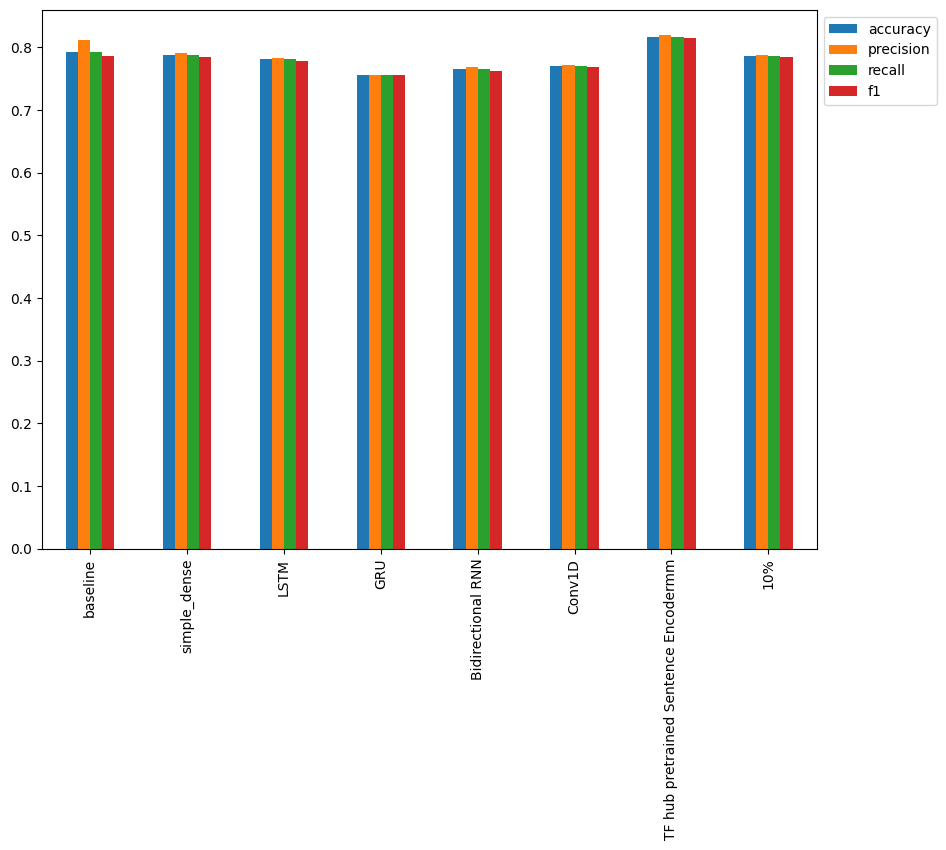

In [127]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

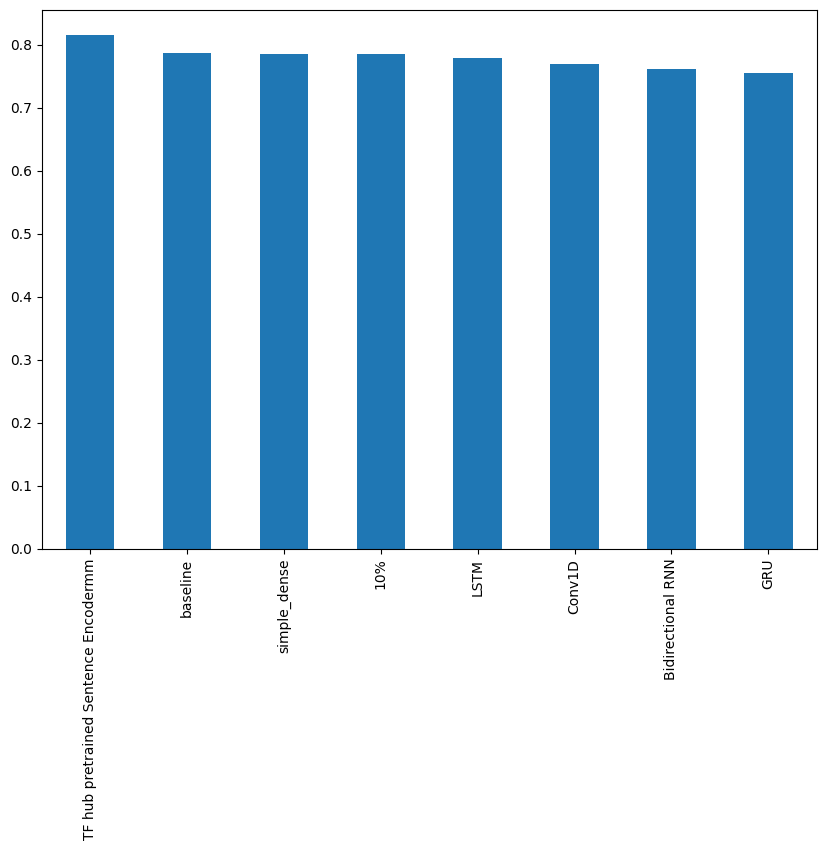

In [128]:
#Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Saving and loading a trained model

There are two main formats to save a model to in Tensorflow:
1. The HDF5 format
2. The `SaveMode` format(this is the default when using TensorFlow)

In [129]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

In [131]:
# Save TF HUB Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [132]:
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})


In [133]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.4304 - accuracy: 0.8163


[0.4304078221321106, 0.8162729740142822]

In [134]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

Now let's save to the `SavedModel` format

In [136]:
# Save TF Hub Sentence Encoder model to savedmodel format (default)
model_6.save("model_6_SavedModel_format")

In [137]:
# Load the saved model
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [138]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 13ms/step - loss: 0.4304 - accuracy: 0.8163


[0.4304078221321106, 0.8162729740142822]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* Which ones are the *most* wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [139]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-12-16 08:05:03--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 142.250.157.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  24.0MB/s    in 40s     

2023-12-16 08:05:44 (22.7 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [140]:
# Import previously trained model from Google storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [142]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 18ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [145]:
# Create DataFrame with validation sentences and best performing model perdictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})

val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [146]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]


,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [147]:
most_wrong.tail() # False positive

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [148]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [149]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.054603397846221924
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.042086850851

## Making predictions on the test dataset

In [151]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 57ms/step
Pred: 1, Prob: 0.9557879567146301
Text:
Good morning. Slept about 6 hours. The heat wave hits Japan... The hot days still continue. I guess some people were killed by this climate.

----

1/1 [==============================] - 0s 56ms/step
Pred: 0, Prob: 0.1318570375442505
Text:
Time is ripe for yet another banana blight: The banana's appeal is not slipping. But the future of bananas is inÛ_ http://t.co/StPS5mruXW

----

1/1 [==============================] - 0s 66ms/step
Pred: 0, Prob: 0.2022930234670639
Text:
Remove http://t.co/GYcBuXfYGP Browser Hijack... http://t.co/FuQH0yKsdg

----

1/1 [==============================] - 0s 40ms/step
Pred: 1, Prob: 0.830946147441864
Text:
Exploration takes seismic shift in Gabon to Somalia http://t.co/dmVR2H2fKM

----

1/1 [==============================] - 0s 37ms/step
Pred: 0, Prob: 0.14761367440223694
Text:
Is Facebook being deluged by friending spam the last few days or is someone targeting 

## Predicting on Tweets from the wild

In [153]:
# Turn tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [155]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [156]:
predict_on_sentence(model=model_6,
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 107ms/step
Pred: 0.0 (not real disaster) Prob: 0.039900004863739014
Text:
Life like an ensemble: take the best choices from others and make your own


## The speed/score tradeoff

In [157]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [161]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 26ms/step


(1.5009385260000272, 0.0019697355984252323)

In [159]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.10782742099945608, 0.00014150580183655654)

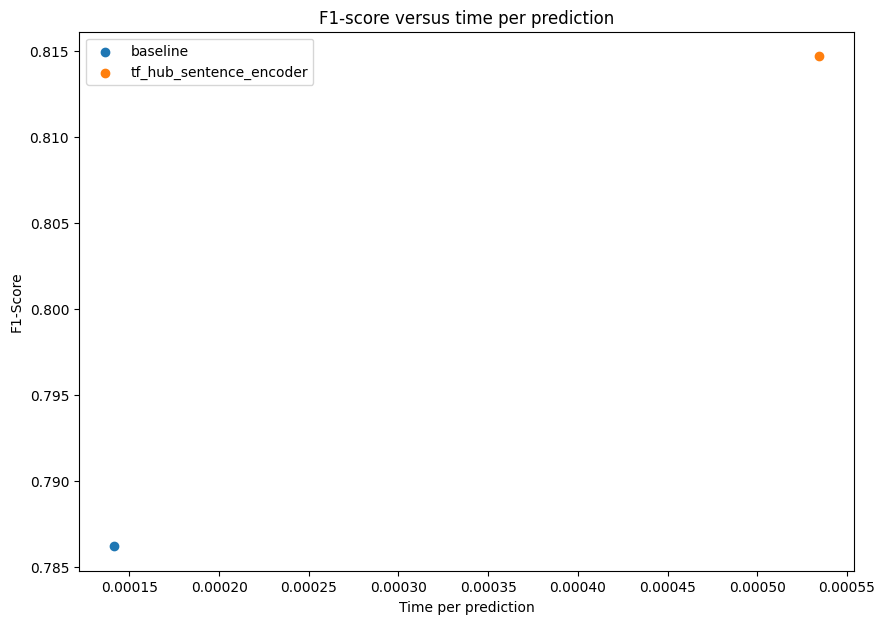

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");